5/5 [==============================] - 0s 4ms/step
Время обучения: 29.16 сек
Время предсказания: 0.5243 сек
MSE: 2139427.02
MAE: 1155.93


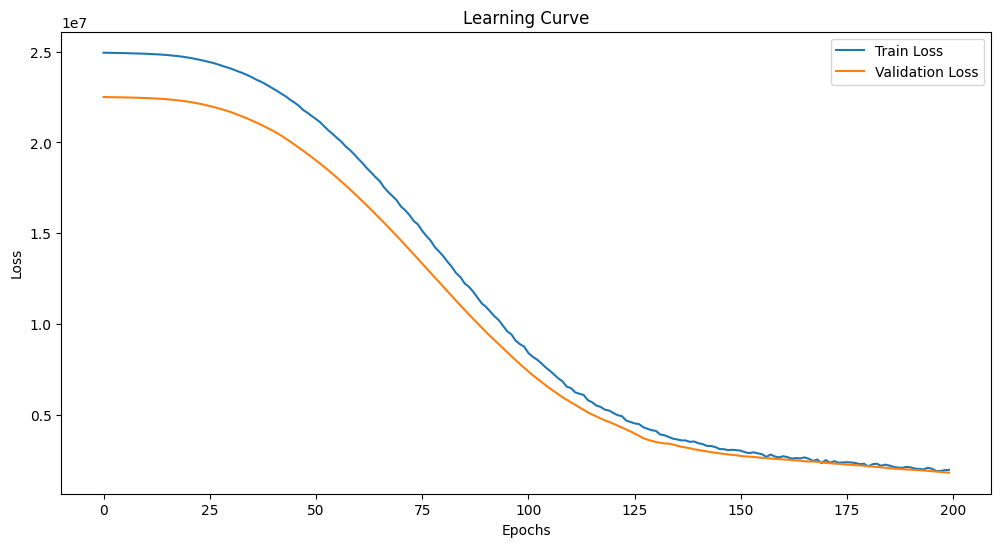

In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time

# 1. Загрузка и предобработка данных
df = pd.read_csv("day.csv")
df = df.drop(['instant', 'dteday', 'casual', 'registered'], axis=1)
df = df.rename(columns={
    'yr': 'year',
    'mnth': 'month',
    'weathersit': 'weather',
    'cnt': 'total_rentals'
})

# 2. Преобразование категориальных признаков
categorical_features = ['season', 'month', 'weekday', 'weather']
df[categorical_features] = df[categorical_features].astype('category')
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# 3. Разделение и масштабирование данных
X = df.drop('total_rentals', axis=1).values
y = df['total_rentals'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4. Создание Transformer модели
def bike_transformer(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # Добавление временной оси для совместимости с attention
    x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
    
    # Позиционные эмбеддинги
    position_embed = layers.Dense(128)(x)
    position_embed = layers.LayerNormalization()(position_embed)
    
    # Multi-Head Attention
    attention = layers.MultiHeadAttention(
        num_heads=4,
        key_dim=32
    )(position_embed, position_embed)
    
    # Residual connection
    x = layers.Add()([position_embed, attention])
    x = layers.LayerNormalization()(x)
    
    # Feed Forward Network
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation='relu')(x)
    
    # Удаление временной оси
    x = layers.Lambda(lambda x: tf.squeeze(x, axis=1))(x)
    
    # Выходной слой
    outputs = layers.Dense(1)(x)
    
    return Model(inputs=inputs, outputs=outputs)

# 5. Сборка и компиляция модели
model = bike_transformer(input_shape=(X_train.shape[1],))
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mse',
    metrics=['mae']
)

# 6. Обучение модели
start_time = time.time()
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=64,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
    ],
    verbose=0
)
train_time = time.time() - start_time

# 7. Предсказание и оценка
start_pred = time.time()
y_pred = model.predict(X_test)
pred_time = time.time() - start_pred

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# 8. Вывод результатов
print(f"Время обучения: {train_time:.2f} сек")
print(f"Время предсказания: {pred_time:.4f} сек")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")

# 9. Визуализация процесса обучения
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()